# Modeling a pandemic

By Christian Graf, August 2020

In this post we want to develop such an agent-based model using python. As an example we try to model the behaviour of a pandemic. Please note that I am not at all an epidemiologist. The goal of this post is not to build a sophisticated model capable of making real life predictions, but rather to see how we can build a simple agent-based model and study some of the resulting dynamics. Let's start with some basic considerations.

### Foundations of Our Model

For our example we assume a non-lethal disease that may spread between individuals which were in contact with each other. The most basic approach is to consider three different groups:
* Individuals that are not yet infected, called the susceptible group.
* Individuals that are infected and may spread the disease.
* Individuals that have recovered from the desease and are now immune.

Because of the three involved groups (Susceptible, Infected, Recovered), these models are also called SIR-Models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd

from tqdm import tqdm

In [2]:
np.random.seed = 42

In [3]:
_nAgents = 1000

In [4]:
_randomContacts = 9
_chanceOfInfection = 0.025

_mortalityRate = 0.05

_daysBeingInfectious = 10
_daysCuredAfter = 10

### Analytical SIR-Model
We will start with a mathematical SIR-model that will serve us as a benchmark model. In the basic SIR-model, the flow between the three groups is: S -> I -> R . It is a one-way street where in the beginning most individuals are in the S group, eventually cascading via the I group into the R group. At each time step t a certain amount of people are traversing from S to I and from I to R, while the total number of individuals N = S+I+R stays constant. We can write these dynamics into a set of differential equations, or, in a bit more understandable form, we can write down by how much each of the groups changes for a certain time step:

In [5]:
# Calculating analytical predictions with SIR-Model
class MathModel:
    S = 0
    I = 0
    R = 0
    
    S_ = []
    I_ = []
    R_ = []
    
    beta = 0
    gamma = 0

    chanceOfInfection = 0
    randomContacts = 0
    daysCuredAfter = 1
    
    def __init__(self, nAgents, nPatientZero, chanceOfInfection, randomContacts, daysCuredAfter):
        
        self.chanceOfInfection = chanceOfInfection
        self.randomContacts = randomContacts
        self.daysCuredAfter = daysCuredAfter
        
        self.S = nAgents - nPatientZero
        self.I = nPatientZero
        self.R = 0
        
        self.S_ = []
        self.I_ = []
        self.R_ = []
        
        self.beta = self.chanceOfInfection*self.randomContacts #contacts with 100% infection rate
        self.gamma = 1./self.daysCuredAfter
    
        print("Math Model initialized with:")
        print("Beta:",self.beta)
        print("Gamma:",self.gamma)
        
    def calculateStep(self):
        N = self.S+self.I+self.R
        
        S = self.S
        I = self.I

        self.S = S - self.beta*S*I/N
        # People who just got infected can be immediately cured. 
        # This may not be very accurate but it is easier to implement
        # In the agent based model
        newI = I + self.beta*S*I/N 
        self.I = I + self.beta*S*I/N - self.gamma*newI
        self.R = self.R + self.gamma*newI
        
        self.S_.append(self.S)
        self.I_.append(self.I)
        self.R_.append(self.R)    

The dynamics are governed by two variables β and γ. While β is the rate with which infectious individuals infect others, γ is the rate at which infectious individuals recover. These dynamics are visualized below for a fixed β and γ:

In [6]:
_nAgents = 10000

_randomContacts = 9
_chanceOfInfection = 0.025
_daysCuredAfter = 10

In [7]:
_nSteps = 120

_nPatientZero = 100

x = np.linspace(0,_nSteps-1,_nSteps)
allStats = []

SIRModel = MathModel(_nAgents, _nPatientZero, chanceOfInfection=0.025, randomContacts=9, daysCuredAfter=10)
print("Simulate SIR Model")
for i in tqdm(range(_nSteps)):        
    SIRModel.calculateStep()

100%|████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 120295.53it/s]

Math Model initialized with:
Beta: 0.225
Gamma: 0.1
Simulate SIR Model


In [8]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

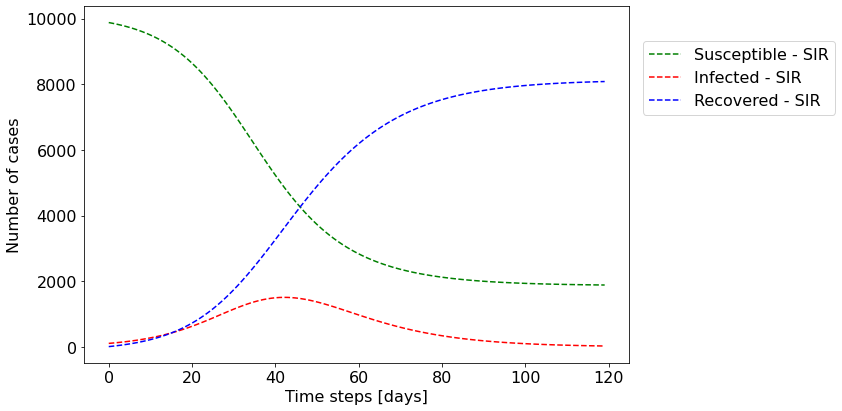

In [9]:
plt.figure(figsize=(12,6))
plt.plot(x,SIRModel.S_,"--", color = "green", label="Susceptible - SIR")
plt.plot(x,SIRModel.I_,"--", color="red", label="Infected - SIR")
plt.plot(x,SIRModel.R_,"--", color="blue", label="Recovered - SIR")

plt.xlabel("Time steps [days]")
plt.ylabel("Number of cases")

lgd = plt.legend(bbox_to_anchor=(1.01,0.8), loc="center left")
plt.tight_layout()

plt.savefig("SIR_baseline.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

You can see that the number of infected individuals grows fast, peaking around day 40 until when the number of susceptible individuals drops significantly, slowing down the rate of infections. This is simply because by then a significant amount of individuals already had the disease and cannot be infected anymore. Towards the end, the number of infected individuals drops to zero, eradicating the disease. Note that by then around 20% of the individuals were never infected. This so-called steady-state solution can also be calculated analytically and depends on the parameters β and γ.
With this simple SIR-model we can alrady observe some basic dynamics for our problem. However, we are looking at our groups only in an aggregate way. We assume that the individuals are an homogeneous, unstructured set of people organized into three well defined, perfectly mixed groups. The interactions that are modeled are only on average. Every infected individual infects on each day a fixed number of people and a constant fraction of all infected individuals is cured each day. There is no way of implementing complex social interactions of individuals within this model. In order to relax some of these assumptions we will now set up an agent-based model simulating each individual separately.

## Agent-Based Model
Our first goal is to reproduce the results from the analytical SIR-model. As a data structure we want to use pandas dataframes. Let's start with initializing 10'000 agents represented as rows in the dataframe:

In [10]:
_nAgents = 10000
state = np.zeros(_nAgents)
data = {"state": state}
df = pd.DataFrame(data)
df.describe()

,state
count,10000.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


Currently, the dataframe has only one row called state which indicates the health state of the agent. We encode susceptible with 0, infected with 1 and recovered with 2.
Now we need some function that infects an agent. We want this function to take a list of agents that were in contact with an infected agent. Additionally, we want to give a probability with which these contacts actually get infected. Here come some Monte Carlo methods into play in order to add randomness. The function below does the required job.

In [11]:
def infect(df, contacts, probability=1.0):
    unique, counts = np.unique(contacts, return_counts=True)
    
    roll = np.random.uniform(0,1,len(unique))

    state = df.loc[unique,"state"]
    probability = 1 - np.power(1-probability, counts)
    change = np.array(roll <= probability).astype(int)
    
    df.loc[unique,"state"] = state + np.maximum(change*(1-state),0)

The list of contacts allows to hold the same agent multiple times. We roll a random number between 0 to 1 for each unique agent in the contact list and update the state from sucseptible (0) to infected (1) if this roll is below a probability threshold. The last line of the function is updating the state column accordingly.
Similarly, we need a function that recovers infected agents with a certain probability. Here, we use a flat chance of recovery in every time step.

In [12]:
def init(nAgents=1000, nPatientZero=1):
    state = np.zeros(nAgents)

    neighborhood = np.zeros(nAgents)
    data = {"state": state, "neighborhood": neighborhood}

    df = pd.DataFrame(data)
    patientZero = np.random.choice(df.index, nPatientZero, replace=False)
    infect(df, patientZero, probability=1.0)
    return df

In [13]:
def recover(df, probability=1.0):    
    roll = np.random.uniform(0,1,len(df[df["state"] == 1]))
    chance = np.array(roll <= probability).astype(int)
    
    df.loc[df["state"] == 1,"state"] = 1 + chance

The infect and recover functions are called at every time step. For this we create a step function. Here, we are generating the list of random contacts which has a length of a constant time the number of infected agents.

In [14]:
def step(df):
    nInfected = np.sum(df["state"] == 1)
    contacts = np.random.choice(df.index, _randomContacts * nInfected, replace=True)

    infect(df, contacts, _chanceOfInfection)
    recover(df, _chanceOfRecovery)

In [15]:
def simulate(df, stats, nSteps=100, mode="random", nRandomContacts=0, plotLattice=False):
    for i in tqdm(range(nSteps)):        
        step(df)
            
        stats["nSusceptible"].append(np.sum(df["state"] == 0))    
        stats["nInfected"].append(np.sum(df["state"] == 1))
        stats["nRemoved"].append(np.sum(df["state"] == 2))


In order to get a feeling for the variations in the outcome of our agent based model we will run the simulation ten times. For each experiment we initialize a set of 10'000 agents with 5 infected patients zero to start with. We then perform 150 time steps.

In [16]:
_randomContacts = 9
_chanceOfInfection = 0.025
_daysCuredAfter = 10
_chanceOfRecovery = 1./_daysCuredAfter

In [17]:
_nExperiments = 10
_nAgents = 10000
_nSteps = 150

_nPatientZero = 5

x = np.linspace(0,_nSteps-1,_nSteps)
allStats = []

SIRModel = MathModel(_nAgents, _nPatientZero, chanceOfInfection=0.025, randomContacts=9, daysCuredAfter=10)
print("Simulate SIR Model")
for i in tqdm(range(_nSteps)):        
    SIRModel.calculateStep()

for iExp in range(_nExperiments):
    print("Starting Experiment:",iExp+1,"/",_nExperiments)
    st = {"nInfected": [], "nRemoved": [], "nSusceptible": []}

    df = init(_nAgents, _nPatientZero)

    simulate(df, stats=st, nSteps=_nSteps)
    
    allStats.append(st)

  7%|█████▍                                                                           | 10/150 [00:00<00:01, 94.60it/s]

Math Model initialized with:
Beta: 0.225
Gamma: 0.1
Simulate SIR Model
Starting Experiment: 1 / 10


  5%|████▎                                                                             | 8/150 [00:00<00:01, 77.10it/s]

Starting Experiment: 2 / 10


  8%|██████▍                                                                         | 12/150 [00:00<00:01, 106.38it/s]

Starting Experiment: 3 / 10


  7%|█████▉                                                                           | 11/150 [00:00<00:01, 98.03it/s]

Starting Experiment: 4 / 10


  7%|█████▍                                                                           | 10/150 [00:00<00:01, 93.00it/s]

Starting Experiment: 5 / 10


  7%|█████▊                                                                          | 11/150 [00:00<00:01, 109.11it/s]

Starting Experiment: 6 / 10


  7%|█████▊                                                                          | 11/150 [00:00<00:01, 109.41it/s]

Starting Experiment: 7 / 10


  8%|██████▍                                                                         | 12/150 [00:00<00:01, 119.88it/s]

Starting Experiment: 8 / 10


  7%|█████▊                                                                          | 11/150 [00:00<00:01, 109.34it/s]

Starting Experiment: 9 / 10


  9%|██████▉                                                                         | 13/150 [00:00<00:01, 117.54it/s]

Starting Experiment: 10 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 82.16it/s]


In [18]:
def calculateStats(allStats):
    medianStats = dict()
    lowerStats = dict()
    higherStats = dict()

    for key in allStats[0]:
        l = []
        for st in allStats:
            l.append(st[key])
        a = np.stack(l)
        medianStats[key] = np.median(a, axis=0)
        lowerStats[key] = np.quantile(a, 0.25, axis=0)
        higherStats[key] = np.quantile(a, 0.75, axis=0)
    
    return medianStats, lowerStats, higherStats

In [19]:
def plotSIR(x,mdianStats,lowerStats,higherStats,SIRModel,figName="tmp.png"):
    plt.plot(x,medianStats["nSusceptible"], color = "green", label="Susceptible")
    plt.plot(x,medianStats["nInfected"], color="red", label="Infected")
    plt.plot(x,medianStats["nRemoved"], color="blue", label="Recovered")
    plt.plot(x,nDead, color="black")
    plt.fill_between(x, lowerStats["nSusceptible"], higherStats["nSusceptible"],
                     color='green', alpha=0.1)
    plt.fill_between(x, lowerStats["nInfected"], higherStats["nInfected"],
                     color='red', alpha=0.1)
    plt.fill_between(x, lowerStats["nRemoved"], higherStats["nRemoved"],
                     color='blue', alpha=0.1)

    plt.plot(x,SIRModel.S_,"--", color = "green", label="Susceptible - SIR")
    plt.plot(x,SIRModel.I_,"--", color="red", label="Infected - SIR")
    plt.plot(x,SIRModel.R_,"--", color="blue", label="Recovered - SIR")

    plt.xlabel("Time steps [days]")
    plt.ylabel("Number of cases")

    lgd = plt.legend(bbox_to_anchor=(1.01,0.65), loc="center left")
    plt.tight_layout()
    
    plt.savefig(figName, bbox_extra_artists=(lgd,), bbox_inches='tight')
   
    plt.show()

### Baseline Results
Visualizing the size of each of the three groups (susceptible, infected and recovered) at each time step, we can see that the dynamics of our agent based model are in agreement with the basic SIR-model.

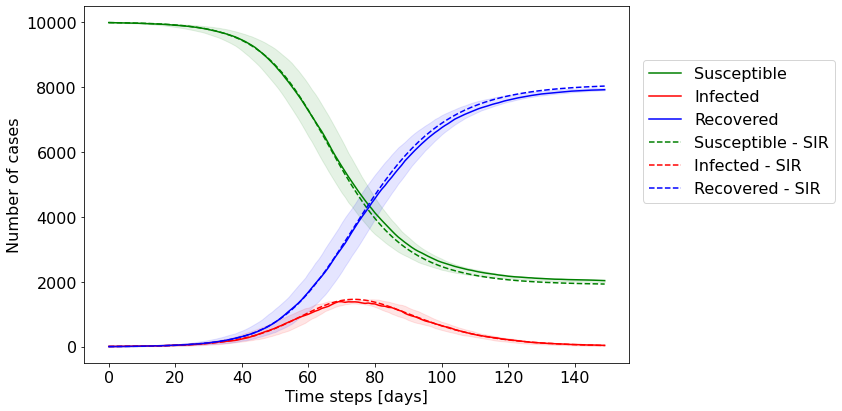

In [20]:
plt.figure(figsize=(12,6))
medianStats, lowerStats, higherStats = calculateStats(allStats)
plotSIR(x,medianStats,lowerStats,higherStats,SIRModel,figName="CompareToSIR.png")

The solid lines show the median of our 10 runs of the simulation, while the shaded area shows the area between the 25%-75% quantile. Even though there is some variance in the central part of the simulation, all models arrive at a very similar endpoint, which equals to the analytical solution.
Up to now we have not gained much over the basic SIR-model, but we have setup an agent-based baseline model and verified that it behaves similar. With this setup we can now start to add extra complexity.

### Spatial Agent-Based Model
It is intuitive that the assumption of infected agent having contact to at set of completely random agents may not hold in real life. You would rather expect some social neighborhood, a group of contacts the infected agents acts with on a regular basis. An easy way of simulating this effect is to place the agents on a lattice and let them interact with their nine closest neighbors.

In [21]:
def buildNeighborhoodLattice(df, nRandomContacts=0):
    sideLength = int(np.sqrt(len(df)))
    N = np.array((df.index - sideLength) % len(df)).astype(int)
    E = np.array(np.floor(df.index / sideLength)*sideLength + (df.index % sideLength + 1) % sideLength).astype(int)
    S = np.array((df.index + sideLength) % len(df)).astype(int)
    W = np.array(np.floor(df.index / sideLength)*sideLength + (df.index % sideLength - 1) % sideLength).astype(int)
        
    NE = np.array((E - sideLength) % len(df)).astype(int)
    SE = np.array((E + sideLength) % len(df)).astype(int)
    SW = np.array((W + sideLength) % len(df)).astype(int)
    NW = np.array((W - sideLength) % len(df)).astype(int)
    
    res = [N,E,S,W,NE,SE,SW,NW]
    
    for i in range(0,nRandomContacts):
        res.append(np.random.choice(df.index, len(df), replace=True))
    
    res = np.array(res).T
    return dict(zip(df.index, res))

In [22]:
def step(df, mode="random", neighborhood=None):
    nInfected = np.sum(df["state"] == 1)
    contacts = []
    if mode=="random":
        contacts = np.random.choice(df.index, _randomContacts * nInfected, replace=True)
    elif mode=="lattice":
        #Check that df can be organised in a square
        assert np.floor(np.sqrt(len(df))) * np.floor(np.sqrt(len(df))) == len(df)
                                                    
        contacts = [neighborhood[i] for i in df[df["state"] == 1].index]
        contacts = np.array(contacts).flatten()

    infect(df, contacts, _chanceOfInfection)
    recover(df, _chanceOfRecovery)

In [23]:
def simulate(df, stats, nSteps=100, mode="random", nRandomContacts=0, plotLattice=False):
    neighborhood = buildNeighborhoodLattice(df, nRandomContacts)
    
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
        
    for i in tqdm(range(nSteps)):        
        step(df, mode, neighborhood)
        if plotLattice:
            sideLength = int(np.sqrt(len(df)))
            a = np.array(df["state"] + df["state"]*(2-df["state"]) + df["state"]/2*(1-df["state"])).reshape(sideLength, sideLength)
            plt.imshow(a)
            plt.title("Time step {:03d}".format(i))
            plt.axis('off')
            plt.savefig("gifs/tmp/{:03d}.png".format(i))
            #plt.show()
            
            
        stats["nSusceptible"].append(np.sum(df["state"] == 0))    
        stats["nInfected"].append(np.sum(df["state"] == 1))
        stats["nRemoved"].append(np.sum(df["state"] == 2))


In [24]:
_randomContacts=9
_chanceOfInfection = 0.06

  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

Math Model initialized with:
Beta: 0.54
Gamma: 0.1
Simulate SIR Model
Starting Experiment: 1 / 10


  2%|█▊                                                                                | 9/400 [00:00<00:05, 77.97it/s]

Starting Experiment: 2 / 10


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

Starting Experiment: 3 / 10


  2%|██                                                                               | 10/400 [00:00<00:04, 92.80it/s]

Starting Experiment: 4 / 10


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

Starting Experiment: 5 / 10


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

Starting Experiment: 6 / 10


  2%|█▍                                                                                | 7/400 [00:00<00:05, 68.90it/s]

Starting Experiment: 7 / 10


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

Starting Experiment: 8 / 10


  2%|█▍                                                                                | 7/400 [00:00<00:06, 62.09it/s]

Starting Experiment: 9 / 10


  2%|█▍                                                                                | 7/400 [00:00<00:05, 68.75it/s]

Starting Experiment: 10 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:05<00:00, 69.38it/s]


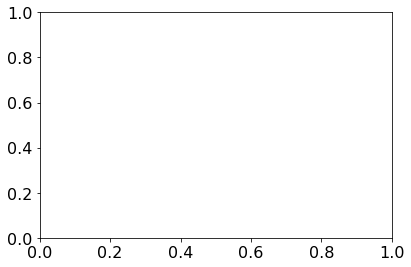

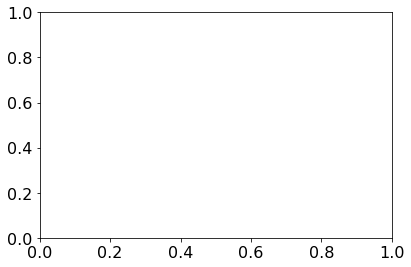

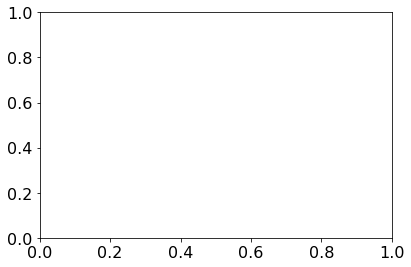

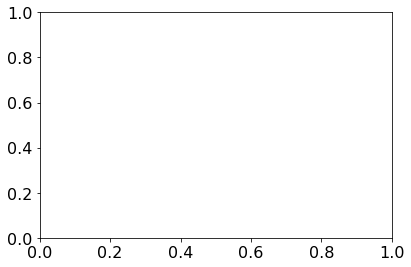

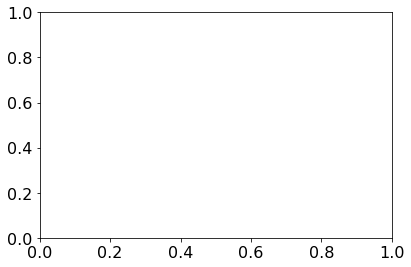

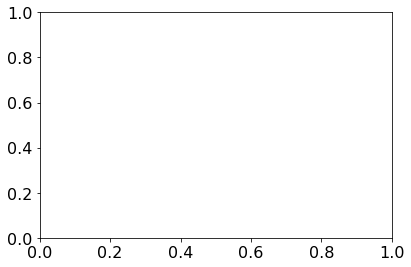

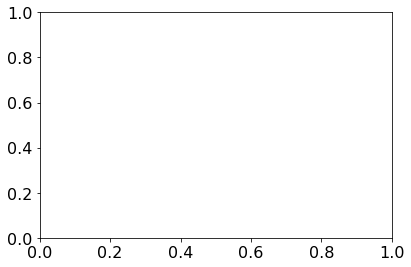

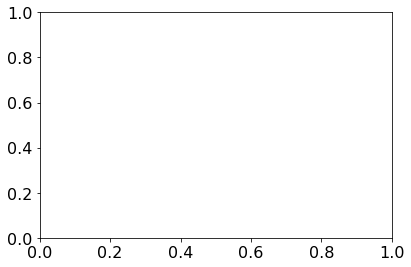

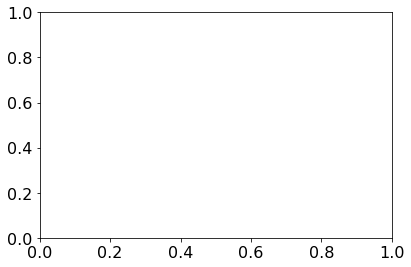

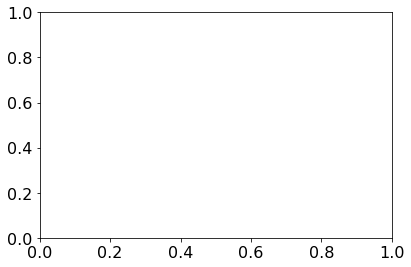

In [25]:
_nSteps = 400

x = np.linspace(0,_nSteps-1,_nSteps)
allStats = []

SIRModel = MathModel(_nAgents, _nPatientZero, _chanceOfInfection, _randomContacts, _daysCuredAfter)
print("Simulate SIR Model")
for i in tqdm(range(_nSteps)):        
    SIRModel.calculateStep()

for iExp in range(_nExperiments):
    print("Starting Experiment:",iExp+1,"/",_nExperiments)
    st = {"nInfected": [], "nRemoved": [], "nSusceptible": []}

    df = init(_nAgents)

    simulate(df, stats=st, nSteps=_nSteps, mode="lattice", nRandomContacts=0, plotLattice=False)
    
    allStats.append(st)

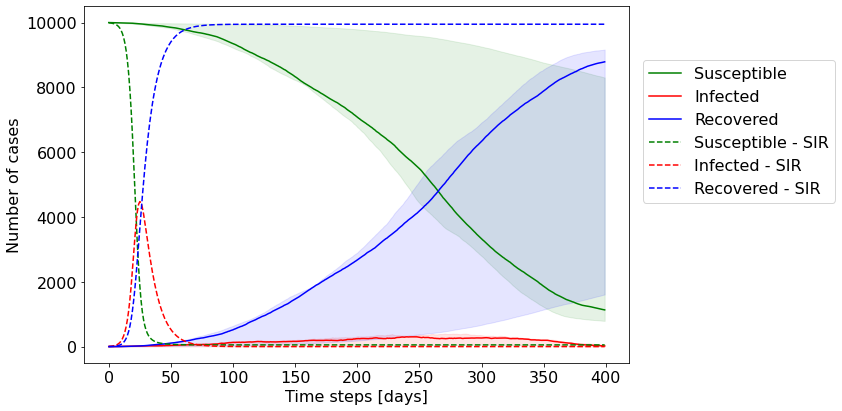

In [26]:
plt.figure(figsize=(12,6))
medianStats, lowerStats, higherStats = calculateStats(allStats)
plotSIR(x,medianStats, lowerStats, higherStats, SIRModel)

Note the prolonged x-axis. You can see that the dynamics are now much slower for the spatial agent based model. I even had to increase the chanceOfInfection significantly, to get it going. The structure that we introduced to the contacts leads to the fact that an infected agent lives in an environment were there are already many agents who are infected as well or have recovered already leading to a significant decrease in the dynamics of the disease.

### Adding Random Contacts
We saw that when we introduce spatial structure to the social interactions of the agents, the dynamics of the disease are slowed down significantly. What happens when we introduce for every agents an additional random contact besided its nine spatial neighbors?

  5%|███▊                                                                              | 7/150 [00:00<00:02, 66.10it/s]

Math Model initialized with:
Beta: 0.54
Gamma: 0.1
Simulate SIR Model
Starting Experiment: 1 / 10


  6%|████▉                                                                             | 9/150 [00:00<00:01, 80.53it/s]

Starting Experiment: 2 / 10


  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

Starting Experiment: 3 / 10


  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

Starting Experiment: 4 / 10


  4%|███▎                                                                              | 6/150 [00:00<00:02, 54.43it/s]

Starting Experiment: 5 / 10


  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

Starting Experiment: 6 / 10


  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

Starting Experiment: 7 / 10


  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

Starting Experiment: 8 / 10


  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

Starting Experiment: 9 / 10


  5%|███▊                                                                              | 7/150 [00:00<00:02, 68.79it/s]

Starting Experiment: 10 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 54.40it/s]


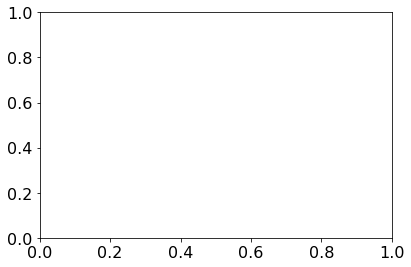

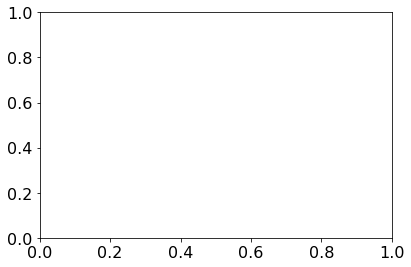

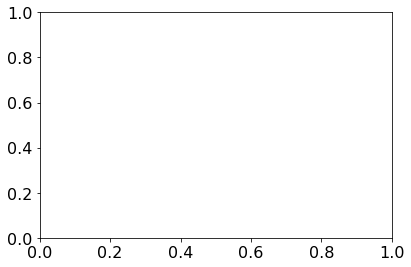

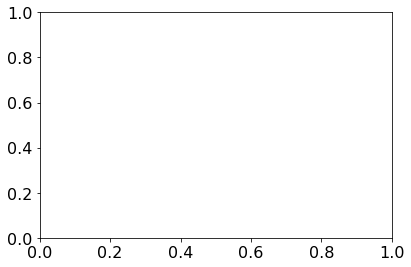

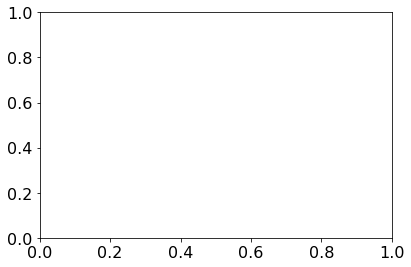

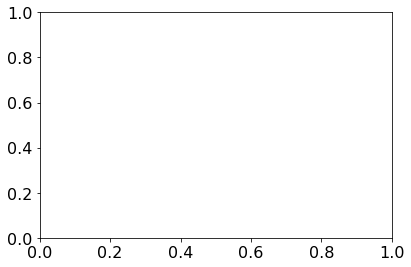

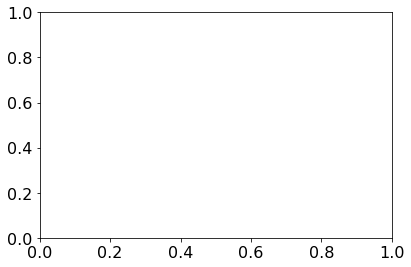

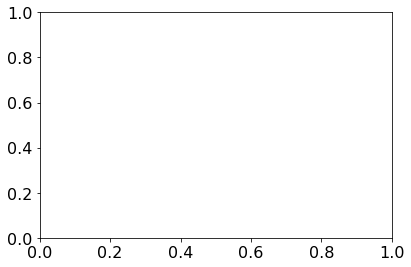

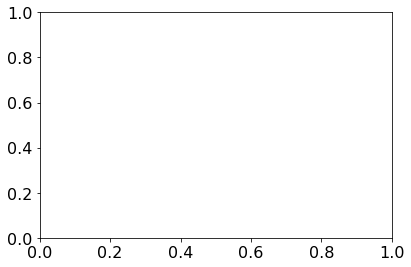

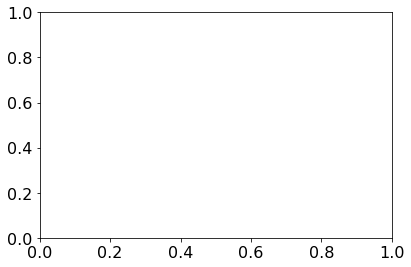

In [27]:
_nSteps = 150

x = np.linspace(0,_nSteps-1,_nSteps)
allStats = []

SIRModel = MathModel(_nAgents, _nPatientZero, _chanceOfInfection, _randomContacts, _daysCuredAfter)
print("Simulate SIR Model")
for i in tqdm(range(_nSteps)):        
    SIRModel.calculateStep()

for iExp in range(_nExperiments):
    print("Starting Experiment:",iExp+1,"/",_nExperiments)
    st = {"nInfected": [], "nRemoved": [], "nSusceptible": []}

    df = init(_nAgents)

    simulate(df, stats=st, nSteps=_nSteps, mode="lattice", nRandomContacts=1, plotLattice=False)
    
    allStats.append(st)

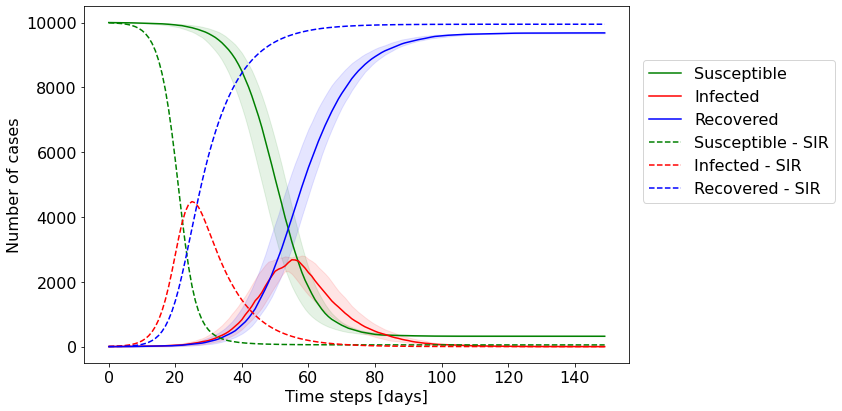

In [28]:
plt.figure(figsize=(12,6))
medianStats, lowerStats, higherStats = calculateStats(allStats)
plotSIR(x, medianStats, lowerStats, higherStats, SIRModel)

With only one additional random contact the dynamics of the infection are again much faster, quickly breaking the structure we introduced by placing the agents on the lattice.